In [2]:
import os
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import datasets, layers, models, metrics, regularizers
import matplotlib.pyplot as plt

# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
%cd /content/drive/MyDrive/CS3540/CS3540-Assignments/final-project/data/
!ls

/content/drive/MyDrive/CS3540/CS3540-Assignments/final-project/data
'Brain_Cancer raw MRI data'   image_data.npy   image_labels.npy


In [24]:
from PIL import Image

#run this if images are not saved locally as np array

#in order for this to work, you need to download the data from kaggle as a zip and upload it to the following directory:
# /content/drive/MyDrive/CS3540/CS3540-Assignments/final-project/data/

glioma_path = 'Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma'
menin_path = 'Brain_Cancer raw MRI data/Brain_Cancer/brain_menin'
tumor_path = 'Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor'

image_data = []
image_labels = []

target_size = (128, 128) # this is a hyper param, rescaled size of images that will be used as the input shape for the CNN



for directory_path in [glioma_path, menin_path, tumor_path]:
    if os.path.exists(directory_path):
        label = os.path.basename(directory_path) # directory corresponds to label
        for filename in os.listdir(directory_path):
            full_path = os.path.join(directory_path, filename)
            if os.path.isfile(full_path):
                try:
                    img = Image.open(full_path).convert('RGB')
                    img_resized = img.resize(target_size) # <- we resize so the image data isn't incredibly huge but still provides enough information to train on
                    img_array = np.asarray(img_resized)
                    image_data.append(img_array)
                    image_labels.append(label)
                except Exception as e:
                    print(f"Error processing {full_path}: {e}")
    else:
        print(f"Directory not found: {directory_path}")

# Convert the lists to numpy arrays
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print("Image data shape:", image_data.shape)
print("Image labels shape:", image_labels.shape)
print("Example labels:", image_labels[:10])

Image data shape: (6056, 128, 128, 3)
Image labels shape: (6056,)
Example labels: ['brain_glioma' 'brain_glioma' 'brain_glioma' 'brain_glioma'
 'brain_glioma' 'brain_glioma' 'brain_glioma' 'brain_glioma'
 'brain_glioma' 'brain_glioma']


In [25]:
# Save the image data and labels
# only run this cell if generating images for the first time after running the above cell
np.save('image_data.npy', image_data)
np.save('image_labels.npy', image_labels)

print("Image data and labels saved as 'image_data.npy' and 'image_labels.npy'")

Image data and labels saved as 'image_data.npy' and 'image_labels.npy'


In [26]:
# Normalize the image data

# run this cell after images have either been loaded or generated in the above cell
for image in image_data:
  image = image / 255

print("Image data normalized.")

Image data normalized.


In [28]:
from sklearn.model_selection import train_test_split

# First split: TRAIN vs TEMP (70% train, 30% temp)
x_train, x_temp, y_train, y_temp = train_test_split(
    image_data,
    image_labels,
    test_size=0.30,
    random_state=42,
    stratify=image_labels # Ensure classes stay balanced
)

# Second split: TEMP into VALIDATION and TEST (15%/15% of total)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp # Ensure classes stay balanced
)

print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_val.shape, y_val.shape)
print("Test: ", x_test.shape, y_test.shape)

Train: (4239, 128, 128, 3) (4239,)
Val:   (908, 128, 128, 3) (908,)
Test:  (909, 128, 128, 3) (909,)


In [29]:
print("Unique classes in test set:", np.unique(image_labels))


Unique classes in test set: ['brain_glioma' 'brain_menin' 'brain_tumor']


In [30]:
#run this cell to change image labels to ints (CNN wants this and won't work without it)

# change labels from strings to int

# Initialize LabelEncoder
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded   = label_encoder.transform(y_val)
y_test_encoded  = label_encoder.transform(y_test)


# Update y_train and y_test to use the encoded labels
y_train = y_train_encoded
y_val = y_val_encoded
y_test = y_test_encoded

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Training data generator with augmentation
train_datagen = ImageDataGenerator(
  rotation_range=10,
  width_shift_range=0.1,
  height_shift_range=0.1,
  zoom_range=0.1,
  horizontal_flip=True
)

# Validation generator
val_datagen = ImageDataGenerator()

# Test generator
test_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow(x_train, y_train_encoded, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(x_val, y_val_encoded, batch_size=32, shuffle=False)
test_generator = test_datagen.flow(x_test, y_test_encoded, batch_size=32, shuffle=False)

In [32]:
class_names = ['glioma', 'menin', 'tumor']

In [33]:
# defining model

model = models.Sequential()

# Flatten image (196,608 features)
model.add(layers.Flatten(input_shape=(128, 128, 3)))

# 3 fully connected layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Output layer (3 total, 1 for each class)
model.add(layers.Dense(len(class_names), activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,626,307 (48.17 MB)

 Trainable params: 12,625,411 (48.16 MB)

 Non-trainable params: 896 (3.50 KB)

In [35]:
# training model

# only run this if weights are not saved locally
# this will take an extraordinarily long time (> 1 hour if you don't have colab pro)
# if you do have colab pro, T4 gpus will speed this up quite a bit, should take ~1 minute.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=20,
                    batch_size=32,
                    validation_data=val_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 160ms/step - accuracy: 0.5817 - loss: 1.0569 - val_accuracy: 0.5881 - val_loss: 1.0701
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.6587 - loss: 0.8106 - val_accuracy: 0.6696 - val_loss: 0.7389
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.6815 - loss: 0.7659 - val_accuracy: 0.7247 - val_loss: 0.6286
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.6745 - loss: 0.7434 - val_accuracy: 0.7170 - val_loss: 0.6433
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.6843 - loss: 0.7411 - val_accuracy: 0.7269 - val_loss: 0.6307
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.6886 - loss: 0.7392 - val_accuracy: 0.7302 - val_loss: 0.6290
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.6872 - loss: 0.7257 - val_accuracy: 0.7324 - val_loss: 0.6315
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 0.6919 - loss: 0.7061 - val

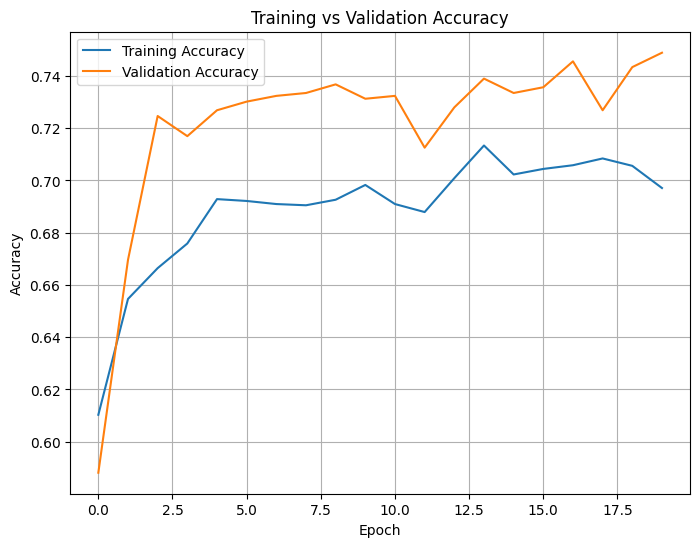

In [36]:

import matplotlib.pyplot as plt

acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])

plt.figure(figsize=(8, 6))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


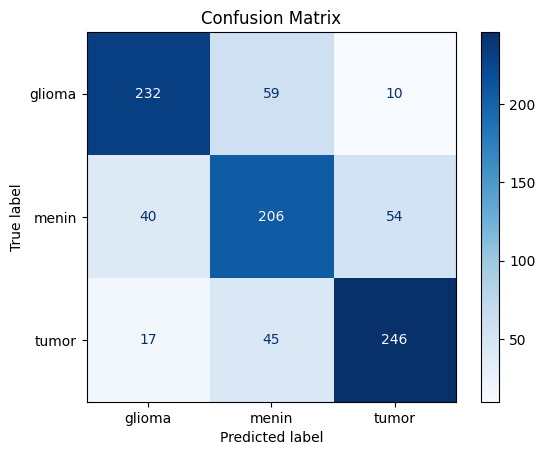

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       301
           1       0.66      0.69      0.68       300
           2       0.79      0.80      0.80       308

    accuracy                           0.75       909
   macro avg       0.75      0.75      0.75       909
weighted avg       0.75      0.75      0.75       909



In [37]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predictions
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Classification report
report = classification_report(y_test_encoded, y_pred)
print("Classification Report:")
print(report)


In [39]:
# Evaluate on test set
loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7626 - loss: 0.5801
Test Loss: 0.5842
Test Accuracy: 0.7525
